In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os
from pathlib import Path

In [2]:
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

In [80]:
simple_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [81]:
train_data_simple = ImageFolder(
    root=train_dir,
    transform=simple_transforms,
    target_transform=None,
)

test_data_simple = ImageFolder(
    root=test_dir,
    transform=simple_transforms,
    target_transform=None
)

In [82]:
class_names = train_data_simple.classes
class_to_idx= train_data_simple.class_to_idx
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [83]:
# turn dataset into dataloader

from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Building TinyVGG

In [87]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel size
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        out = self.classifier(x)
        return out

In [88]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [89]:
simple_input, simple_label = next(iter(train_dataloader_simple))
simple_input.shape, simple_label.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [90]:
model_simple = TinyVGG(3, 64, len(class_names)).to(device=device)
model_simple

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10816, out_features=3, bias=True)
  )
)

In [91]:
model_simple(simple_input.to(device)).shape

torch.Size([16, 3])

## Using torchinfo to get summary of our model

In [93]:
from torchinfo import summary

summary(model_simple, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 3]                   --
├─Sequential: 1-1                        [16, 64, 30, 30]          --
│    └─Conv2d: 2-1                       [16, 64, 62, 62]          1,792
│    └─ReLU: 2-2                         [16, 64, 62, 62]          --
│    └─Conv2d: 2-3                       [16, 64, 60, 60]          36,928
│    └─ReLU: 2-4                         [16, 64, 60, 60]          --
│    └─MaxPool2d: 2-5                    [16, 64, 30, 30]          --
├─Sequential: 1-2                        [16, 64, 13, 13]          --
│    └─Conv2d: 2-6                       [16, 64, 28, 28]          36,928
│    └─ReLU: 2-7                         [16, 64, 28, 28]          --
│    └─Conv2d: 2-8                       [16, 64, 26, 26]          36,928
│    └─ReLU: 2-9                         [16, 64, 26, 26]          --
│    └─MaxPool2d: 2-10                   [16, 64, 13, 13]          --


# Training loop

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_simple.parameters(),
                            lr=0.001)

In [95]:
from tqdm.auto import tqdm

In [96]:
def accuracy_fn(y_true, y_pred):
    return (y_true==y_pred).sum().item()/len(y_true)

In [97]:
from timeit import default_timer as timer

In [98]:
def train(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               epochs: int,
               device = device):
    
    start_time = timer()
    model.train()
    
    losses = []
    acc = []

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0, 0
        
        # loop through data loader
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X) # model logits

            # Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            
            # Optimizer zero grad
            optimizer.zero_grad()
            
            # Loss backward 
            loss.backward()
            
            # Optimizer step
            optimizer.step()

            # Calculate accuracy metric
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += accuracy_fn(y, y_pred_class)
        
        # Get average loss and accuracy per batch
        avg_loss = train_loss / len(dataloader)
        avg_acc = train_acc / len(dataloader)

        losses.append(avg_loss)
        acc.append(avg_acc)

        if epoch%20==0:
            print(f"Epoch: {epoch}\nTrain loss: {avg_loss:.4f} | Train acc: {avg_acc:.4f}")
    
    end_time = timer()
    print(f"Total training time: {end_time - start_time:.3f} seconds!")
    return losses, acc

In [99]:
losses, acc = train(model=model_simple,
                    dataloader=train_dataloader_simple,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.0860 | Train acc: 0.3583
Epoch: 20
Train loss: 0.0768 | Train acc: 0.9792
Epoch: 40
Train loss: 0.0004 | Train acc: 1.0000
Total training time: 34.401 seconds!


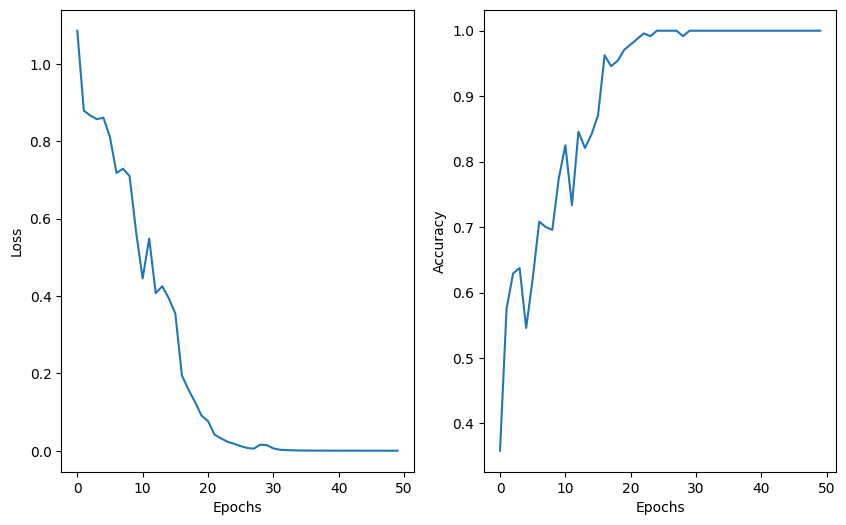

In [100]:
import matplotlib.pyplot as plt
def plot_loss_and_accuracy(losses, acc):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    ax[0].plot(losses)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].plot(acc)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    
plot_loss_and_accuracy(losses, acc)

In [101]:
def testing(model: nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: nn.Module,
            device = device):
    model.eval()

    with torch.inference_mode():
        losses, acc = [], []
        test_loss, test_acc = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # forward pass
            test_pred_logits = model(X)

            # calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            losses.append(loss.item())
            
            test_pred_class = torch.argmax(test_pred_logits, dim=1)
            accuracy = accuracy_fn(y, test_pred_class)
            test_acc += accuracy
            acc.append(accuracy)
        
        avg_loss = test_loss / len(dataloader)
        avg_acc = test_acc / len(dataloader)
        print(f"\nTest loss: {avg_loss:.4} | Test acc: {avg_acc:.4f}")

In [102]:
testing(model=model_simple,
        dataloader=test_dataloader_simple,
        loss_fn=loss_fn,
        device=device)


Test loss: 4.89 | Test acc: 0.5341


# Model building with data augmentation

In [105]:
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [106]:
train_data = ImageFolder(root=train_dir,
                         transform=train_transforms,
                         target_transform=None)

test_data = ImageFolder(root=test_dir,
                        transform=test_transforms,
                        target_transform=None)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)  

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [107]:
model = TinyVGG(input_shape=3, hidden_units=32, output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [108]:
losses, acc = train(model=model,
                    dataloader=train_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.1087 | Train acc: 0.2917
Epoch: 20
Train loss: 0.7971 | Train acc: 0.6625
Epoch: 40
Train loss: 0.6822 | Train acc: 0.7000
Total training time: 34.439 seconds!


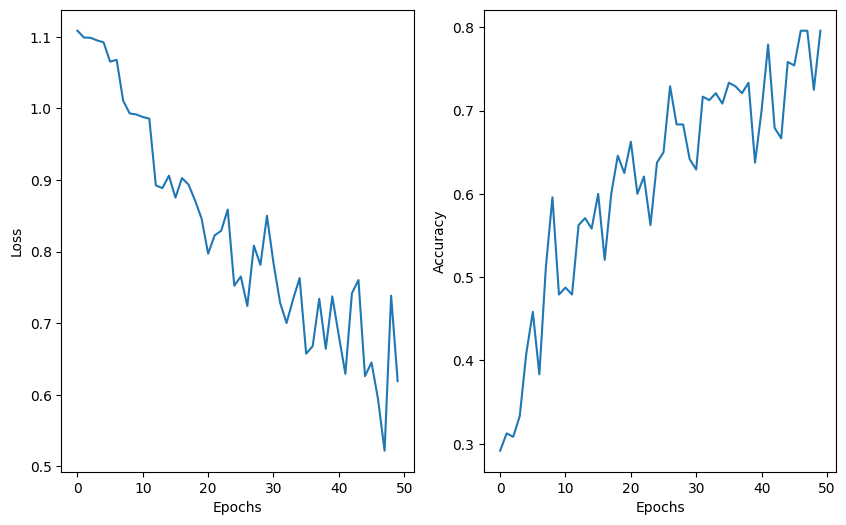

In [111]:
plot_loss_and_accuracy(losses, acc)

In [112]:
testing(model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn)


Test loss: 1.001 | Test acc: 0.5148


# testing on custom image

In [122]:
from torchvision.io import read_image
from PIL import Image

In [134]:
img_path = 'sushi.png'
img = read_image(img_path).type(torch.float32)
pil_img = Image.open(img_path)

In [135]:
rescaled_img = img/255.
rescaled_img.shape

torch.Size([3, 275, 183])

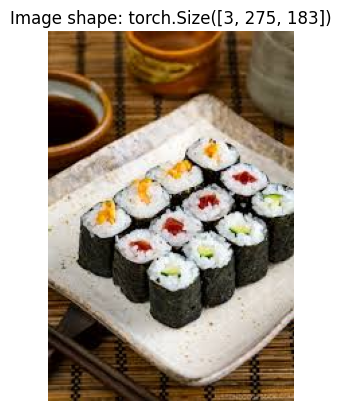

In [140]:
plt.imshow(rescaled_img.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {rescaled_img.shape}")
plt.axis(False);

In [141]:
custom_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image = custom_transform(rescaled_img)

# Print out original shape and new shape
print(f"Original shape: {rescaled_img.shape}")
print(f"New shape: {custom_image.shape}")

Original shape: torch.Size([3, 275, 183])
New shape: torch.Size([3, 64, 64])


In [142]:
model.eval()
with torch.inference_mode():
    custom_image_batched = custom_image.unsqueeze(0).to(device)
    custom_image_preds = model(custom_image_batched)

In [144]:
custom_image_prob = torch.softmax(custom_image_preds, dim=1)
custom_image_prob

tensor([[0.2694, 0.0063, 0.7243]], device='cuda:0')

In [145]:
custom_image_predicted_class = custom_image_prob.argmax(axis=1)
class_names[custom_image_predicted_class]

'sushi'

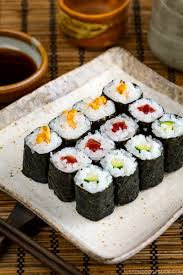

In [146]:
pil_img

# Building pipeline for custom image

In [155]:
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

def predict_custom_image(image_path: str,
                         model: nn.Module=model,
                         class_names=class_names):
    img = read_image(image_path).type(torch.float32)
    model.eval()
    with torch.inference_mode():
        img = img / 255.
        
        custom_transform = transforms.Compose([
            transforms.Resize(size=(64, 64))
        ])
        
        img = custom_transform(img)

        batched_img = img.unsqueeze(0).to(device)
        
        predicted_logits = model(batched_img)
        
        predicted_probabilities = predicted_logits.softmax(dim=1)
        max_prob = predicted_probabilities.max()
        
        predicted_label = predicted_probabilities.argmax(dim=1)
        
        predicted_class = class_names[predicted_label]
        
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Pred: {predicted_class} | Prob: {max_prob:.2f}")
    plt.axis(False)

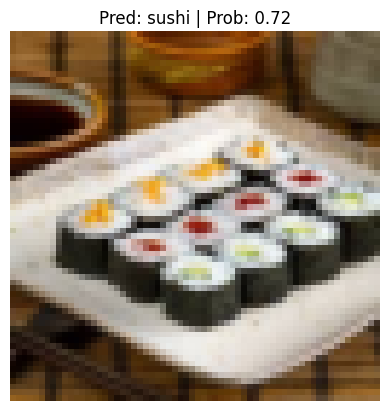

In [157]:
custom_image = 'sushi.png'
predict_custom_image(custom_image)

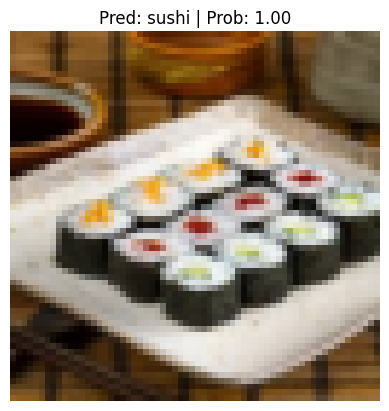

In [158]:
predict_custom_image(custom_image, model_simple)

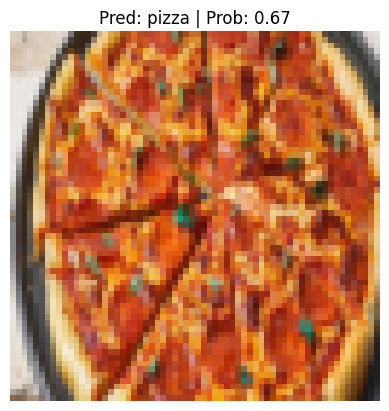

In [163]:
custom_image = "pizza.png"
predict_custom_image(custom_image, model)

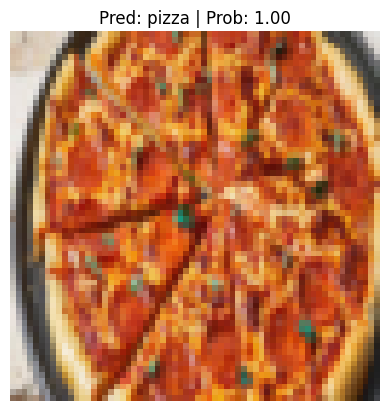

In [164]:
predict_custom_image(custom_image, model_simple)